In [1]:
# imports and env't config 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import json
import requests 
from imp import reload 
import Util; reload(Util)
from datetime import datetime as dt
import seaborn as sns
import warnings
from pygeolib import GeocoderError
import time 
import Cdf
import Pmf
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data = webget_2016 = pd.read_csv("../dataset/speedtest.csv", sep = ',', encoding = "ISO-8859-1")

In [3]:
data.head()

,unit_id,dtime,target,address,fetch_time,bytes_total,bytes_sec,bytes_sec_interval,warmup_time,warmup_bytes,sequence,threads,successes,failures,location_id
0,19602,2015-05-10 00:48:07,ispmon.samknows.mlab2v4.prg01.measurement-lab.org,212.162.51.94,10000094,1644480,164446,164446,5000073,708480,0,3,1,0,596890
1,19602,2015-05-10 06:49:18,ispmon.samknows.mlab2v4.prg01.measurement-lab.org,212.162.51.94,10000105,1154880,115487,115487,5000061,704160,0,3,1,0,596890
2,19602,2015-05-10 12:48:06,ispmon.samknows.mlab2v4.prg01.measurement-lab.org,212.162.51.94,10000093,1676160,167614,167614,5000063,744480,0,3,1,0,596890
3,19602,2015-05-10 18:48:13,ispmon.samknows.mlab2v4.prg01.measurement-lab.org,212.162.51.94,10000090,1255680,125567,125567,5000063,789120,0,3,1,0,596890
4,19602,2015-05-10 19:48:39,ispmon.samknows.mlab2v4.prg01.measurement-lab.org,212.162.51.94,10000091,1238400,123839,123839,5000062,735840,0,3,1,0,596890


In [4]:
# restart the dataload before this... this has to be upto seconds format :)
data['dtime'] = data['dtime'].apply(Util.round_time_to_month) #may require to reload the csv ;) 
data = data[(data['dtime'] >= '2014-01') & (data['dtime'] < '2017-07')]

In [5]:
trupt_grouped = data.groupby(["unit_id", "dtime"])
trupt_mnth_median = trupt_grouped.aggregate({"bytes_sec":np.median})
trupt_df = trupt_mnth_median.reset_index(level=['unit_id', 'dtime'])
trupt_df['bytes_sec'] = trupt_df['bytes_sec'].div(100000)

In [6]:
trupt_df.head()

,unit_id,dtime,bytes_sec
0,19602,2014-01,1.45136
1,19602,2014-02,1.56885
2,19602,2014-03,2.19700
3,19602,2014-04,2.25404
4,19602,2014-05,2.16934


In [7]:
def stop_plot_box(ax, shrink_right = False, fs = 18):
    ax.set_title("")
    plt.suptitle("")
    ax.grid(False)
    # iterate over boxes and change the colors
    for i,box in enumerate(ax.artists):
        box.set_edgecolor('black')
        box.set_facecolor('white')
        
    ax.set_ylim([0, 501])
    ax.set_yscale('symlog')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_position(('axes', -0.05))
    ax.spines['left'].set_position(('axes', -0.015))
    ax.set_xlabel('', fontsize=fs)
    major_ticks = np.arange(0, 42, 6)                                              
    minor_ticks = np.arange(0, 42, 1) 
    ax.set_xticks(minor_ticks, minor=True)                                           
    ax.set_xticks(major_ticks, minor=False)                                           
    labels = ['Jan\n2014 ','Jul', 'Jan\n2015 ','Jul',
          'Jan\n2016 ',' Jul','Jan\n2017 ']
    ax.set_xticklabels(labels)    

def boxplot_sorted(df, by, column, ax, rot = 0):
    medianprops = dict(linestyle='--', color = 'blue', linewidth=2)
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    props = dict(boxes="black", whiskers="black", medians="black")
    meds = df2.median()#.sort_values() # for sorting by median 
    return df2[meds.index].plot.box(ax = ax, rot = rot,  vert = True, color=props,
                                   medianprops = medianprops, showfliers = False, 
                                   return_type = "axes")

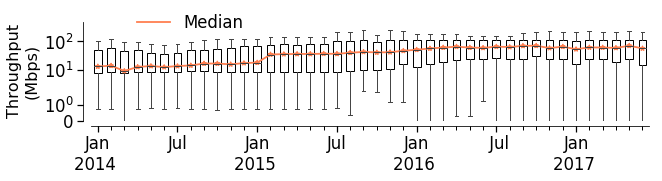

In [8]:
fig = plt.figure(figsize=(10,4))
plt.rcParams['font.size'] = 14

ax1 = fig.add_subplot(211)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})

g = sns.pointplot(x='dtime', y='bytes_sec', 
              data=trupt_df.groupby('dtime', as_index=False).median(), ax=ax1,
             markers=["*"], linestyles=["-"], color="coral",
             join=True)
g.set(xticklabels=[])
g.set_ylabel('')
plt.legend(["Median Throughput"])
plt_trupt = sns.boxplot(x="dtime", y="bytes_sec", data=trupt_df,linewidth=1, width=0.6, showfliers=False, ax=ax1)

stop_plot_box(plt_trupt,  fs = 18)
ax1.legend(["Median"], bbox_to_anchor=(0.3, 0.75), frameon=False)

ax1.set_ylabel('Throughput\n(Mbps)', fontsize=16)
plt.savefig('../gfx/webget_st_thrput_box.pdf', format='pdf', bbox_inches='tight')